In [255]:
# Importing libraries
import os
import re
import cv2
import joblib
import numpy as np
import pandas as pd
from skimage import color
from PIL import ImageEnhance
from skimage.feature import hog
from PIL import ImageOps
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

filenum= 0

In [13]:
### Reading annotations and labels for training data

train_img_label_file = os.path.join(os.getcwd(), "Data/labels_training.csv")

train_images = pd.read_csv(train_img_label_file,
                           sep=',', 
                           header='infer')

In [22]:
train_images.head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


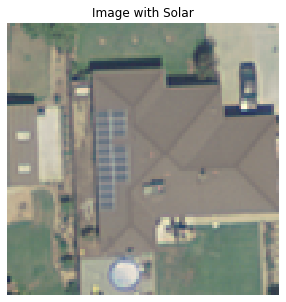

In [194]:
idx = 6
pth = 'Data/training/'+str(train_images.loc[idx,'id'])+'.tif'
image = Image.open(pth)
plt.imshow(image)
plt.axis("off")
plt.title("Image with Solar")
plt.show()

In [166]:
### Reading labels for test data

test_img_label_file = os.path.join(os.getcwd(), "Data/sample_submission.csv")

test_images = pd.read_csv(test_img_label_file,
                          sep=',', 
                          header='infer')

In [170]:
test_images.head()

,id,score
0,1500,0.667875
1,1501,0.527676
2,1502,0.929963
3,1503,0.833491
4,1504,0.337914


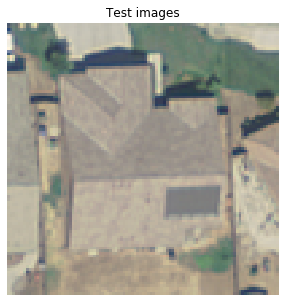

In [195]:
idx = 6
pth = 'Data/testing/'+str(test_images.loc[idx,'id'])+'.tif'
image = Image.open(pth)
plt.imshow(image)
plt.axis("off")
plt.title("Test images")
plt.show()

### Checking different transformation

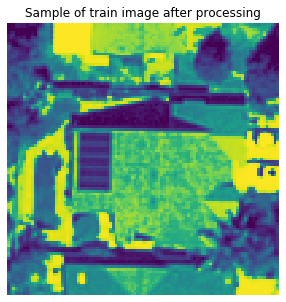

In [260]:
# Testing image processing methods 
# Cropping using annotations and changing it to greyscale along with equalizing

idx = 10
pth = 'Data/training/'+str(train_images.loc[idx,'id'])+'.tif'
image = Image.open(pth)
#red, green, blue = image.split()
#image = ImageOps.invert(image)
image = ImageEnhance.Contrast(image).enhance(2)
image = ImageOps.grayscale(image)
image = ImageOps.equalize(image)
#image = image.rotate(45)

plt.imshow(image)
plt.axis('off')
plt.title("Sample of train image after processing")
plt.show()

****

## Image Processing and HOG

### Function for Image Processing

In [261]:
# Image processing, changing it to greyscale along with equalizing and resizing

def image_processor(label_df,test=False):
    '''
    function to read and pre process training images with labels
    Returns a numpy array of images
    '''
    angle = [0,45,90,135]
    train_img_arr = []
    num_images = len(label_df)
    for i in range(num_images):
        
        pth   = 'Data/training/'+str(label_df.loc[i,'id'])+'.tif'
        if test :
            pth   = 'Data/testing/'+str(label_df.loc[i,'id'])+'.tif'
        image = Image.open(pth)
        
        # image operations
        image = ImageEnhance.Contrast(image).enhance(2)
        image = ImageOps.grayscale(image)
        image = ImageOps.equalize(image)
        image = np.asarray(image.resize([64,64]),dtype="int32")
        
        train_img_arr.append(image) 
        
    print("\nImage Processing done. Processed {} images with {} features \n"
          .format(len(train_img_arr),np.shape(train_img_arr)[1:])) 
    
    return np.array(train_img_arr)

### Function definition for Histogram of Oriented Gradients

In [262]:
def HOG(img_arr,ppc=16,cpb=2):
    hog_images = []
    hog_features = []
    for image in img_arr:
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),
                           cells_per_block=(cpb, cpb),block_norm= 'L2',visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)
        
    print("\nHOG Completed on {} images, with {} features\n"
          .format(np.shape(hog_features)[0],np.shape(hog_features)[1]))   
    
    return hog_images, hog_features

In [263]:
# Processing the training images 

train_data = image_processor(train_images)
y = train_images['label']

# Applying HOG on training Images 
hog_images, hog_features = HOG(train_data)


Image Processing done. Processed 1500 images with (64, 64) features 



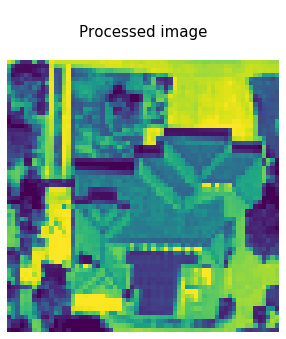

In [284]:
plt.imshow(train_data[4])
plt.axis('off')   
plt.title("\nProcessed image\n", size=15)
plt.show()

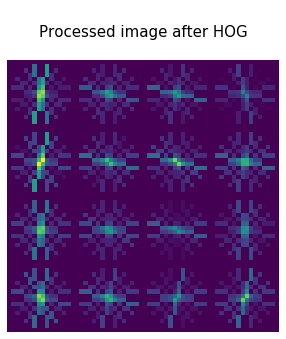

In [283]:
plt.imshow(hog_images[4])
plt.axis('off')   
plt.title("\nProcessed image after HOG\n", size=15)
plt.show()

In [267]:
# Feature Scaling

feature_vec_train = np.array(hog_features)
sc = StandardScaler()
feature_vec_train = sc.fit_transform(feature_vec_train)

### Performing Cross-Validation using the entire training data

In [268]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

clfs = svm.SVC(probability=True)
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(feature_vec_train, y)

pred_score = np.empty(len(y),dtype='object')


for train_index, test_index in skf.split(feature_vec_train, y):
    cross_X_train, cross_X_test = feature_vec_train[train_index], feature_vec_train[test_index]
    cross_y_train = y[train_index]

    clfs.fit(cross_X_train,cross_y_train)
    
    y_score = clfs.predict_proba(cross_X_test)
    pred_score[test_index] = y_score[:,1]

In [269]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
plt.rcParams["figure.figsize"] = (5,5)

In [270]:
fpr, tpr, _ = roc_curve(y, pred_score, pos_label=1)
auc_score = roc_auc_score(y, pred_score)

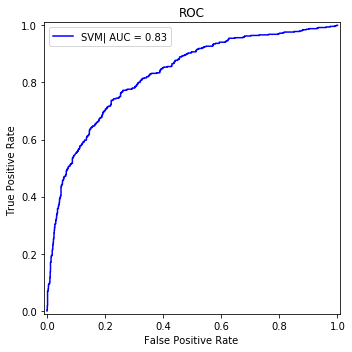

In [271]:
plt.plot(fpr,tpr,'b', label = 'SVM| AUC = %s'%(round(auc_score,2)))
#plt.plot([0, 1], [0, 1],'r--', label = "Chance")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate ')
plt.xlabel('False Positive Rate ')
plt.title("ROC")
plt.legend()
plt.tight_layout()

*****

## Testing model performance on the Test images

In [276]:
#Training the classifier on the actual training dataset with 4536 annotated logo images
clf = svm.SVC(probability=True)
clf.fit(feature_vec_train, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Pre-processing test images

In [277]:
test_data = image_processor(test_images,test=True)
#test_data.shape
test_hog_images, test_hog_features = HOG(test_data)

feature_vec_test = np.array(test_hog_features)


Image Processing done. Processed 558 images with (64, 64) features 


HOG Completed on 558 images, with 288 features



In [ ]:
# Feature scaling
feature_vec_test = sc.transform(feature_vec_test)

In [279]:
# Performing Prediction 
tes_pred = clf.predict_proba(feature_vec_test)

In [281]:
# Saving the ouput 

output = pd.DataFrame({'id': test_images['id']})
output['score'] = np.nan
output['id'] = test_images['id']
output["score"] = np.nan
for i in range(len(output)):
    output.iloc[i,1] = tes_pred[i,1]   
f_name = "Submission/hog_submission_"+str(filenum)+".csv"
output.to_csv(f_name,index=False)
filenum +=1

In [ ]:
output